# This notebook

This particular notebook will explore using both the log return of the close price as input to make forecasts. Perhaps the normalization distribution of log returns will aid the algorithm.

# Import utils and helper functions

In [1]:
%run utils.ipynb

2.4.1


# Get the stocks data

In [2]:
df = get_stocks_df()

Connecting to the PostgreSQL database...
Connection successful


In [3]:
df.head()

,close,volume
dt,,
2015-10-08 13:40:00+00:00,242.50,0.050000
2015-10-08 13:41:00+00:00,242.95,0.001000
2015-10-08 13:42:00+00:00,242.95,NaN
2015-10-08 13:43:00+00:00,242.96,0.010000
2015-10-08 13:44:00+00:00,242.96,0.033491


## Resample to daily and impute any missing values

In [4]:
# Close price is last
daily_df = df.resample('D').last()

In [5]:
daily_df['close'].isnull().sum()

30

In [6]:
daily_df['close'] = daily_df['close'].fillna(method='ffill')

In [7]:
daily_df['close'].isnull().sum()

0

In [9]:
daily_df['log_returns'] = compute_log_returns(daily_df['close'])

In [10]:
daily_df.head()

,close,volume,log_returns
dt,,,
2015-10-08 00:00:00+00:00,243.95,5.211300,NaN
2015-10-09 00:00:00+00:00,245.39,0.000800,0.005885
2015-10-10 00:00:00+00:00,246.30,4.410000,0.003702
2015-10-11 00:00:00+00:00,249.50,0.402812,0.012909
2015-10-12 00:00:00+00:00,247.60,3.400000,-0.007644


# Attempt 1

This attempt uses 128 neurons, a window size of 5 (meaning the previous 5 values are used to make the prediction of the next value),
and an output size of 1 (meaning just 1 price point ahead is forecast). It uses daily data, and we train over a few years

The dataset is the log returns and we scaler with the standard scaler

In [11]:
## Config dict that defines this attempt
config = {
    "neurons": 128,                 # number of hidden units in the LSTM layer
    "activation_function": 'tanh',   # activation function for LSTM and Dense layer
    "loss": 'mse',                   # loss function for calculating the gradient, in this case Mean Squared Error. Could be mae
    "optimizer": 'adam',              # optimizer for appljying gradient decent
    "dropout": 0.25,                 # dropout ratio used after each LSTM layer to avoid overfitting
    "batch_size": 128,              
    "epochs": 4,                  
    "window_len": 15,                 # is an int to be used as the look back window for creating a single input sample.
    "training_size": 0.8,            # porportion of data to be used for training
    "shuffle_buffer": 1000,          # When shuffling the windowed Dataset how many at once to load into memory
    "output_size": 1,
    "start_date": '2018-01-01',
    "end_date": '2021-02-19',
}

In [20]:
scaler, model_training_data, training_data, test_data, training_dates, test_dates = preprocessing(daily_df.iloc[1:], scaler='standard', colname='log_returns', **config)

Standard scaler


In [21]:
# Clean up the memory
tf.keras.backend.clear_session()
model = build_model(config['output_size'], config['neurons'], config['activation_function'],
                     config['dropout'], config['loss'], config['optimizer'], input_shape=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 25)          150       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         78848     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 210,711
Trainable params: 210,711
Non-trainable params: 0
__________________________________________________

In [22]:
history = model.fit(model_training_data, epochs=config['epochs'], batch_size=config['batch_size'], verbose=1)

Epoch 1/4
8/8 [==============================] - 4s 104ms/step - loss: 0.9108 - mae: 0.5795
Epoch 2/4
8/8 [==============================] - 1s 78ms/step - loss: 1.1293 - mae: 0.6010
Epoch 3/4
8/8 [==============================] - 1s 79ms/step - loss: 0.8327 - mae: 0.5483
Epoch 4/4
8/8 [==============================] - 1s 76ms/step - loss: 1.0629 - mae: 0.5973


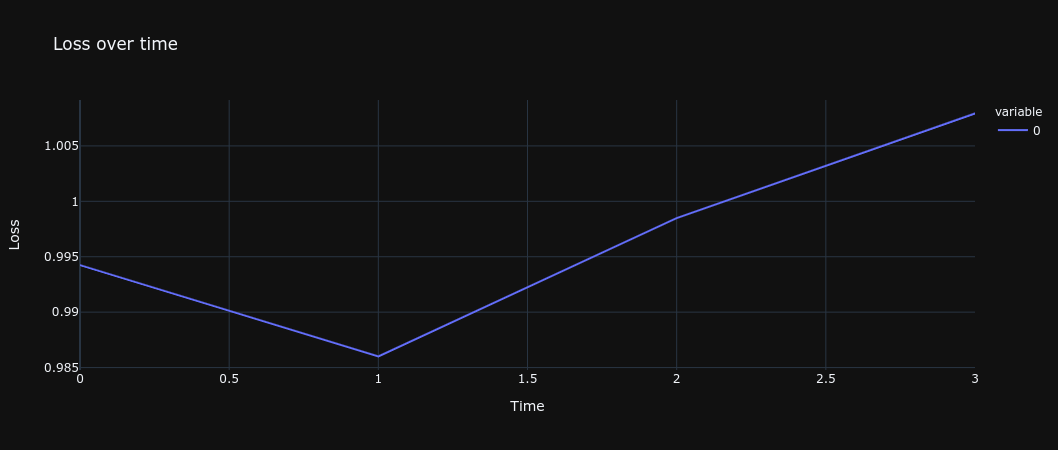

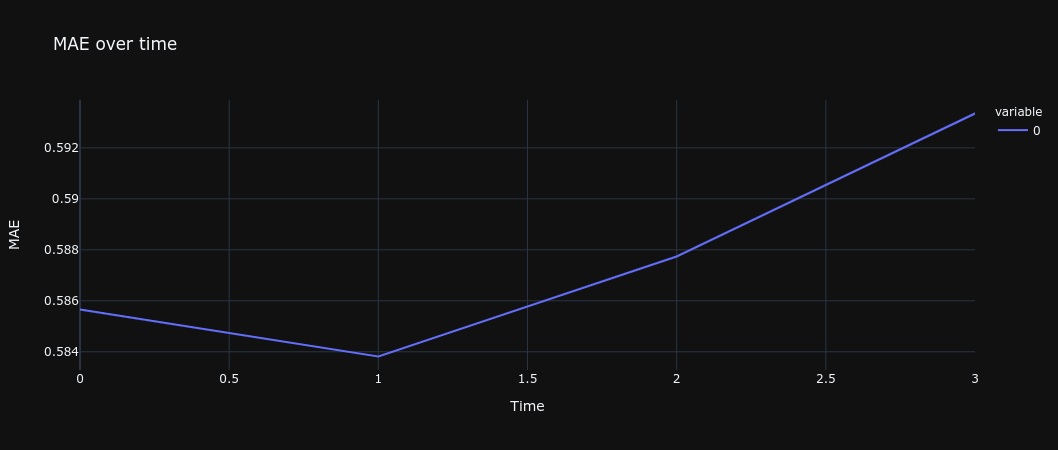

In [23]:
display_history(history)

In [ ]:
# TODO: new display_log_ret_returns....get price zero convert back to prices

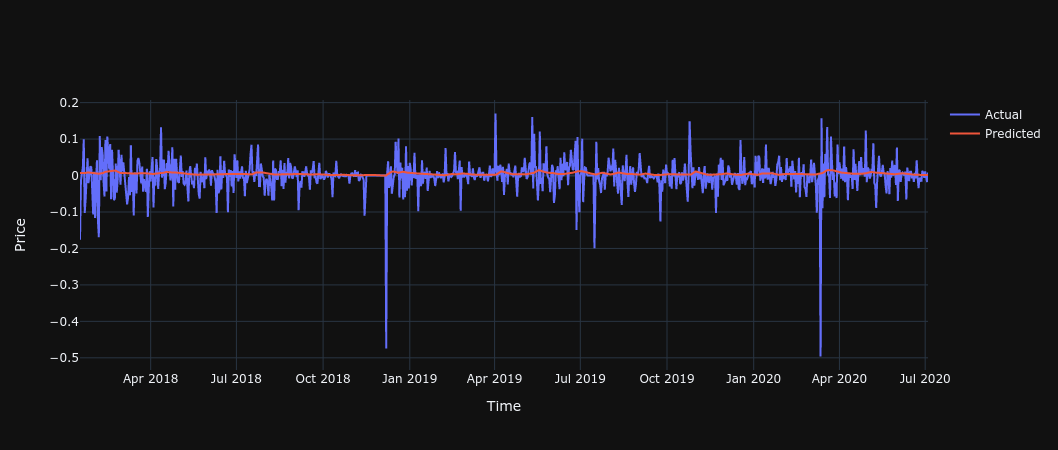

The MAE is 0.588413124279651


In [25]:
train_res_df = display_results(model, scaler, training_data, training_dates, config['window_len'], config['output_size'],
                               multivar=False)

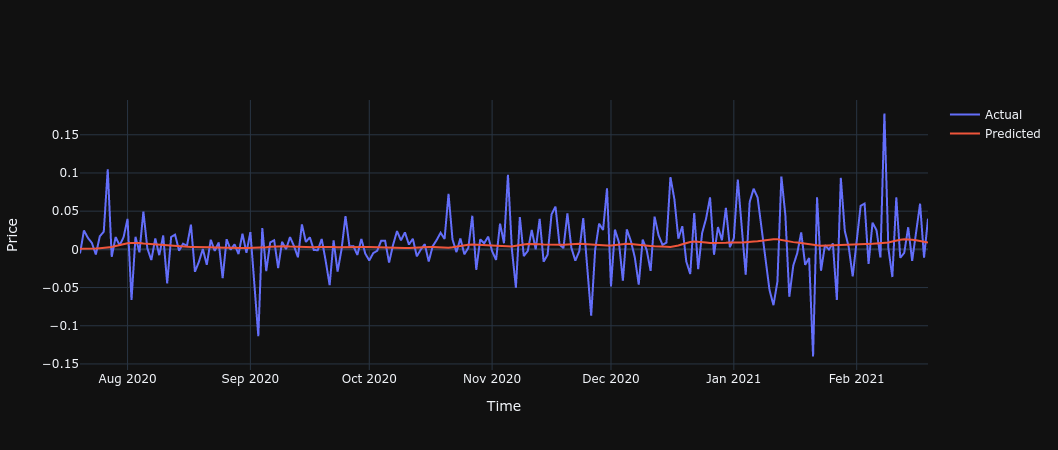

The MAE is 0.5648723683695952


In [26]:
test_res_df = display_results(model, scaler, test_data, test_dates, config['window_len'], config['output_size'], multivar=False)

## Summary

Despite the normalirty of log returns, the series seems to wild to have any trends and the LSTM does not perform well.